In [79]:
# Импортируем необходимые библиотеки для анализа данных

import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [80]:
# Считаем все дата-сеты и посмотрим на их содержимое/типы данных

In [81]:
groups = pd.read_csv('groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [82]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [83]:
group_add = pd.read_csv('group_add.csv')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [84]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [85]:
active_studs = pd.read_csv('active_studs.csv')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [86]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [87]:
checks = pd.read_csv('checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [88]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [89]:
# Добавим информацию о пользователях, полученную через 2 дня, в основной файл:
groups = pd.concat([groups, group_add])
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [90]:
# Отберём только тех пользователей, которые заходили на платформу в дни эксперимента:

groups = groups.rename(columns={'id': 'student_id'}) #переименуем колонку, на основании которой вмёрджим только активных в дни эксперимента пользователей
filtered_groups = groups.merge(active_studs, on='student_id', how='inner')

In [91]:
# Добавим информацию об оплатах пользователей в дни проведения эксперимента:

df = filtered_groups.merge(checks, on='student_id', how='left')
df

,student_id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN
...,...,...,...
8336,5760471,B,NaN
8337,5777081,B,NaN
8338,5870856,A,NaN
8339,5945085,B,NaN


In [92]:
# Проверим, сколько у нас получилось активных платящих пользователей:

df[df.rev > 0].shape

(392, 3)

In [93]:
# По какой-то причине из 541й оплаты в финальном датафрейме осталось только 392 записи.
# Значит в данных есть какой-то баг. Скорее всего, есть пользователи, которые оплатили (их id есть в таблице checks), но при этом они не активные (их id нет в таблице active_studs)
# Давайте это проверим. Для этого замерджим таблицу active_studs и checks по id пользователей:

active_studs.merge(checks, on='student_id', how='inner')

,student_id,rev
0,1184303,1530.0000
1,3354191,1900.0001
2,3278734,1900.0000
3,720651,1980.0000
4,1232221,1900.0000
...,...,...
387,3890326,199.0000
388,1390994,398.0000
389,1516339,290.0000
390,3910596,597.0000


In [94]:
# И действительно мы видим, что строк осталось только 392.
# Соответственно чтобы это исправить, необходимо добавить в таблицу active_studs информацию о 149 id, которые почему-то ранее не попали в неё.
# Для этого:

# Получаем ID студентов, которых не хватает
missing_ids = set(checks['student_id']) - set(active_studs['student_id'])
print(f'Недостающих студентов: {len(missing_ids)}')

# Создаём датафрейм с недостающими студентами
missing_df = pd.DataFrame({'student_id': list(missing_ids)})

# Объединяем с активными
active_updated = pd.concat([active_studs, missing_df], ignore_index=True).drop_duplicates()

Недостающих студентов: 149


In [95]:
# И теперь добавим к нашему финальному датафрейму 149 недостающих записей об оплатах:

filtered_groups = groups.merge(active_updated, on='student_id', how='inner')
df = filtered_groups.merge(checks, on='student_id', how='left')

# Проверим, действительно ли теперь есть записи обо всех активных и платящих пользователях:
df[df.rev > 0].shape

(541, 3)

In [96]:
# Да, все ОК. Теперь теперь все 541 оплаты учтены в финальном датафрейме.
# Предобработка данных завершена. Приступим к самому анализу метрик и поиску инсайтов.

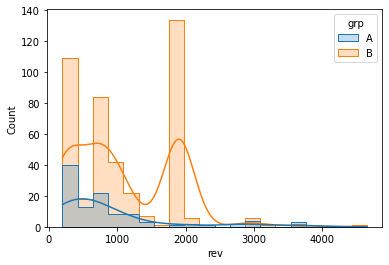

In [97]:
# Посмотрим на распределение выручки в разрезе групп:

sns.histplot(data=df, x='rev', hue='grp', bins=20, kde=True, element='step')

In [98]:
# Как видно из графика выше, по тестовой группе оплат у нас больше.
# Давайте теперь более детально посмотрим, сколько студентов и оплат в каждой группе, а также какая конверсия в оплату у разных групп.

# Кол-во Студентов:

group_sizes = df.groupby('grp').agg({'student_id': 'count'}).rename(columns=({'student_id': 'cnt'}))
print(group_sizes)

      cnt
grp      
A    1567
B    6923


In [99]:
# Кол-во Оплат:

payments = df.groupby('grp').agg({'rev': 'count'}).rename(columns=({'rev': 'cnt'}))
print(payments)

     cnt
grp     
A    107
B    434


In [100]:
# Конверсия

conversion_rate = payments / group_sizes
print(conversion_rate)

          cnt
grp          
A    0.068283
B    0.062690


In [101]:
# Итак, разница в конверсии между тестовой и контрольной группой составила ~0.56%. 
# Давайте проверим, является ли разница между группами A и B статистически значимой.
# Нулевая гипотеза (H₀): Конверсии в группах A и B одинаковы.
# Альтернативная гипотеза (H₁): Конверсии в группах A и B различаются.

In [102]:
# Применим в рамках проверки z-тест для пропорций.

# Число оплат в каждой группе
successes = df.groupby('grp')['rev'].count().values

# Общее количество пользователей в каждой группе
samples = df.groupby('grp')['student_id'].count().values

# z-тест для пропорций
z_stat, p_val = proportions_ztest(successes, samples)

print(f"Z-статистика: {z_stat:.3f}")
print(f"P-значение: {p_val:.5f}")

Z-статистика: 0.819
P-значение: 0.41300


In [103]:
# P-значение 0.413 > 0.05, поэтому мы не можем отвергнуть нулевую гипотезу.
# Нет статистически значимых различий между группами A и B.
# Разница в конверсии (6.83% vs 6.27%) может быть обусловлена случайностью.

In [104]:
# Давайте посмотрим на разницу в группах в рамках другой метрики: Доход на платящего пользователя (ARPPU).
arppu = df[df['rev'] > 0].groupby('grp')['rev'].mean()
print(arppu)

grp
A     860.710280
B    1108.824893
Name: rev, dtype: float64


In [105]:
# Судя по визуализации выше, распределение выручки не является нормальным. Но давайте ещё раз перепроверим это тестом Шапиро-Уилка.

group_A = df[(df['rev'] > 0) & (df['grp'] == 'A')]['rev'] #платящие пользователи из контрольной группы
group_B = df[(df['rev'] > 0) & (df['grp'] == 'B')]['rev'] #платящие пользователи из тестовой группы

shapiro_A = ss.shapiro(group_A)
shapiro_B = ss.shapiro(group_B)

print("Shapiro A:", shapiro_A)
print("Shapiro B:", shapiro_B)

Shapiro A: ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)
Shapiro B: ShapiroResult(statistic=0.8672363758087158, pvalue=8.947892893418603e-19)


In [106]:
# P-значение у обеих групп ниже 0.05, поэтому мы не можем принять нулевую гипотезу у нормальности распределений.

In [107]:
# Проверим гомогенность дисперсий тестом Левене:
stat, p = ss.levene(group_A, group_B)
print(f"Levene test: stat = {stat:.4f}, p = {p:.4f}")

Levene test: stat = 4.4789, p = 0.0348


In [108]:
# P-значение выше 0.05, поэтому мы не можем отклонить нулевую гепотезу о равенстве дисперсий.

In [128]:
# Согласно тесту Шапиро–Уилка, распределения выручки в обеих группах ненормальны (p < 0.05), при этом дисперсии групп равны (тест Левене: p = 0.0803).
# В связи с нарушением предпосылки нормальности, t-тест не применим. Вместо него используем бутстрап с 10 000 итерациями, что обеспечить корректную оценку разницы средних (ARPPU) при произвольных распределениях.

In [130]:
# Бутрстрап

# Параметры
n_iterations = 10000
np.random.seed(42)  # для воспроизводимости

# Bootstrap
boot_diffs = []

for _ in range(n_iterations):
    sample_A = np.random.choice(group_A, size=len(group_A), replace=True)
    sample_B = np.random.choice(group_B, size=len(group_B), replace=True)
    diff = sample_B.mean() - sample_A.mean()  # разница B - A
    boot_diffs.append(diff)

# Конвертируем в массив
boot_diffs = np.array(boot_diffs)

# Доверительный интервал
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)

# Средняя разница
mean_diff = boot_diffs.mean()

# Результаты
print(f"Средняя разница (B - A): {mean_diff:.4f}")
print(f"95% доверительный интервал: [{ci_lower:.4f}, {ci_upper:.4f}]")

Средняя разница (B - A): 248.0895
95% доверительный интервал: [72.8740, 412.6419]


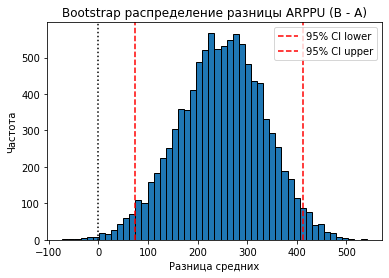

In [131]:
# Визуализация бутстрапа:

plt.hist(boot_diffs, bins=50, edgecolor='k')
plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI lower')
plt.axvline(ci_upper, color='red', linestyle='--', label='95% CI upper')
plt.axvline(0, color='black', linestyle=':')
plt.title('Bootstrap распределение разницы ARPPU (B - A)')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [140]:
# 95% доверительный интервал не содержит 0
# Разница средних доходов от платящих пользователей между группами A и B статистически значима на уровне 95%.
# Группа B приносит в среднем на 248 рубль больше на одного пользователя, чем группа A.
# Мы можем с высокой уверенностью сказать, что новая механика оплаты услуг увеличивает ARPPU.

In [137]:
# Создадим таблицу метрик
metrics = pd.DataFrame({
    'Метрика': ['Конверсия в оплату (CR)', 'ARPPU (₽)'],
    'Группа A': ['6.83%', '860.71₽'],
    'Группа B': ['6.27%', '1108.82₽'],
    'Разница': ['-0.56%', '+248.08₽'],
    'Стат. значимость': ['❌ Нет', '✅ Есть']
})

In [114]:
# ИТОГИ A/B-ТЕСТА

# Цель: оценить влияние новой механики оплаты на поведение пользователей и выручку.

In [138]:
# Ключевые метрики:
print(metrics)

                   Метрика Группа A  Группа B   Разница Стат. значимость
0  Конверсия в оплату (CR)    6.83%     6.27%    -0.56%            ❌ Нет
1                ARPPU (₽)  860.71₽  1108.82₽  +248.08₽           ✅ Есть


In [116]:
# Конверсия в оплату немного ниже в новой группе, но не статистически значимо (p = 0.413). 
# Однако, новая механика приводит к существенному росту ARPPU: +248.08₽.
# Пользователи, платящие по новой механике, платят значимо больше. 
# Разница в доходе подтверждена bootstrap-анализом (95% доверительный интервал не содержит 0).

In [117]:
# Рекомендация: Рекомендуется внедрить новую механику на всех пользователей, так как она значимо увеличивает средний доход на платящего пользователя без ущерба для конверсии.

In [ ]:
# Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [149]:
def analyze_ab_test_with_additional_data(
    groups_path='groups.csv',
    groups_add_path='group_add.csv',
    active_path='active_studs.csv',
    checks_path='checks.csv',
    unify_column_names=True,
    perform_bootstrap=True,
    n_boot=10000,
    seed=42
):
    # Шаг 1: Загрузка и объединение групп
    groups = pd.read_csv(groups_path, sep=';')
    groups_add = pd.read_csv(groups_add_path)

    if unify_column_names:
        groups.columns = groups.columns.str.lower().str.strip()
        groups_add.columns = groups_add.columns.str.lower().str.strip()
        groups = groups.rename(columns={'id': 'student_id'})
        groups_add = groups_add.rename(columns={'id': 'student_id'})

    groups_full = pd.concat([groups, groups_add], ignore_index=True)

    # Шаг 2: Загрузка активных пользователей и оплат
    active = pd.read_csv(active_path)
    active.columns = active.columns.str.lower().str.strip()

    checks = pd.read_csv(checks_path, sep=';')
    checks.columns = checks.columns.str.lower().str.strip()

    # Шаг 3: Создание списка активных (включая тех, кто оплатил, но не был активен)
    active_ids = set(active['student_id'])
    check_ids = set(checks['student_id'])

    # Вычисляем недостающих активных пользователей из checks
    missing_ids = check_ids - active_ids
    if missing_ids:
        print(f"⚠️ Найдено {len(missing_ids)} пользователей в checks, которых нет в active_studs. Добавляем их.")
        # Создаём датафрейм с недостающими
        missing_active = pd.DataFrame({'student_id': list(missing_ids)})
        # Добавляем к списку активных
        active = pd.concat([active, missing_active], ignore_index=True)

    # Шаг 4: Фильтрация только активных пользователей
    groups_active = groups_full[groups_full['student_id'].isin(active['student_id'])]

    # Присоединяем группы к чекам
    df = checks.merge(groups_active, on='student_id', how='inner')
    df['grp'] = df['grp'].str.upper().str.strip()

    # Метрика 1: Конверсия
    total_users = groups_active.groupby('grp')['student_id'].nunique()
    payers = df.groupby('grp')['student_id'].nunique()
    conversion = (payers / total_users).fillna(0)

    # Метрика 2: ARPU
    arpu = df.groupby('grp')['rev'].mean()

    # Метрика 3: Mann-Whitney U
    group_a = df[df['grp'] == 'A']['rev']
    group_b = df[df['grp'] == 'B']['rev']
    stat, p_mw = ss.mannwhitneyu(group_a, group_b, alternative='two-sided')

    # Метрика 4: Bootstrap
    boot_result = None
    if perform_bootstrap:
        np.random.seed(seed)
        boot_diffs = []
        for _ in range(n_boot):
            sample_a = np.random.choice(group_a, size=len(group_a), replace=True)
            sample_b = np.random.choice(group_b, size=len(group_b), replace=True)
            boot_diffs.append(sample_b.mean() - sample_a.mean())
        boot_diffs = np.array(boot_diffs)
        ci_low = np.percentile(boot_diffs, 2.5)
        ci_high = np.percentile(boot_diffs, 97.5)
        boot_result = {
            'mean_diff': boot_diffs.mean(),
            'ci_95': (ci_low, ci_high),
            'significant': ci_low > 0 or ci_high < 0
        }

    # Финальный результат
    result = {
        'conversion': conversion.to_dict(),
        'ARPU': arpu.to_dict(),
        'Mann-Whitney p-value': round(p_mw, 5),
        'bootstrap_ARPU_diff': boot_result
    }

    return result


In [150]:
# Вызовем функцию, введя название файла с доп. пользователями, который нам прислали

result = analyze_ab_test_with_additional_data(groups_add_path='group_add.csv')
print(result)

⚠️ Найдено 149 пользователей в checks, которых нет в active_studs. Добавляем их.
{'conversion': {'A': 0.06828334396936822, 'B': 0.06268958543983821}, 'ARPU': {'A': 860.7102803738318, 'B': 1108.824893087558}, 'Mann-Whitney p-value': 0.00019, 'bootstrap_ARPU_diff': {'mean_diff': 248.08951962716958, 'ci_95': (72.8739569218635, 412.64191730064806), 'significant': True}}


In [ ]:
# Реализуем функцию, которая будет строить графики по получаемым метрикам.

In [151]:
# Решение:

def plot_ab_metrics(conversion_dict, arpu_dict):
    # Стиль
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Конверсия
    ax = axes[0]
    conv_data = pd.DataFrame(list(conversion_dict.items()), columns=['Group', 'Conversion'])
    sns.barplot(data=conv_data, x='Group', y='Conversion', palette='pastel', ax=ax)
    ax.set_title('Конверсия в оплату')
    ax.set_ylabel('Доля оплат')
    ax.set_ylim(0, conv_data['Conversion'].max() * 1.2)

    # 2. ARPPU
    ax = axes[1]
    arpu_data = pd.DataFrame(list(arpu_dict.items()), columns=['Group', 'ARPU'])
    sns.barplot(data=arpu_data, x='Group', y='ARPU', palette='muted', ax=ax)
    ax.set_title('ARPU (средняя выручка на пользователя)')
    ax.set_ylabel('Рубли')
    ax.set_ylim(0, arpu_data['ARPU'].max() * 1.2)

    plt.tight_layout()
    plt.show()

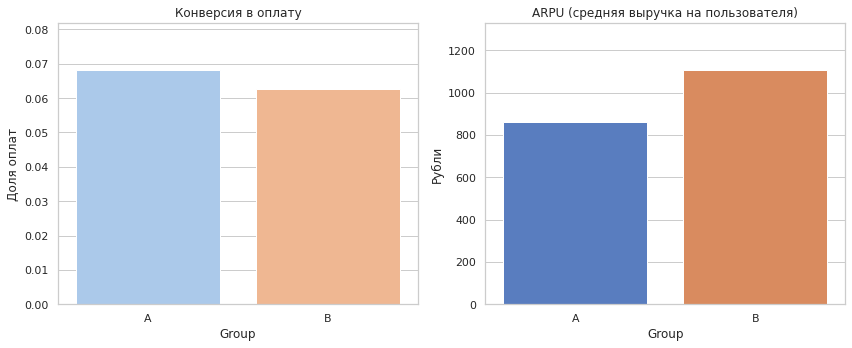

In [152]:
# Вызовем функцию, введя в неё результаты рассчитаных выше метрик:

plot_ab_metrics(conversion_dict=result['conversion'], arpu_dict=result['ARPU'])